In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv('feedbacks.csv')
print(df.shape)

(361, 6)


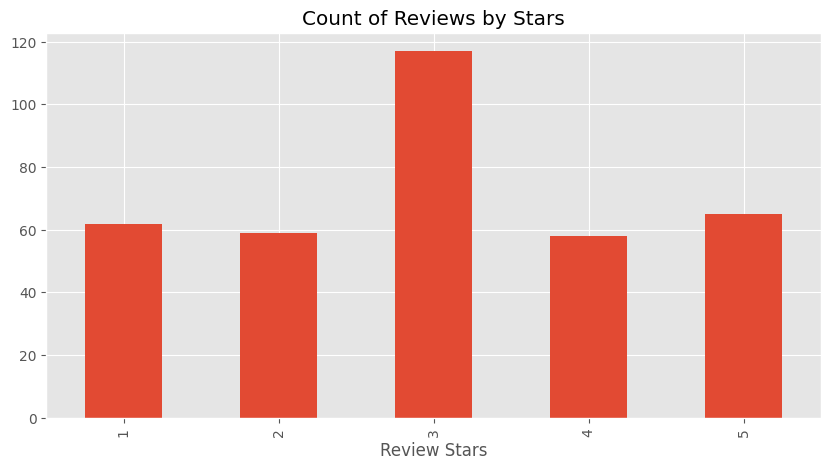

In [3]:
ax = df['REVIEW'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [4]:
example = df['FEEDBACK'][10]
print(example)

The session was too long and felt overwhelming. Breaking it into smaller, more digestible modules would help maintain focus. By the end, attention levels dropped. More concise sessions with short breaks would be beneficial.


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\dhanu/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [6]:
import nltk
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to C:\Users\dhanu/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['The',
 'session',
 'was',
 'too',
 'long',
 'and',
 'felt',
 'overwhelming',
 '.',
 'Breaking']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('The', 'DT'),
 ('session', 'NN'),
 ('was', 'VBD'),
 ('too', 'RB'),
 ('long', 'JJ'),
 ('and', 'CC'),
 ('felt', 'VBD'),
 ('overwhelming', 'VBG'),
 ('.', '.'),
 ('Breaking', 'VBG')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  The/DT
  session/NN
  was/VBD
  too/RB
  long/JJ
  and/CC
  felt/VBD
  overwhelming/VBG
  ./.
  Breaking/VBG
  it/PRP
  into/IN
  smaller/JJR
  ,/,
  more/RBR
  digestible/JJ
  modules/NNS
  would/MD
  help/VB
  maintain/VB
  focus/NN
  ./.
  By/IN
  the/DT
  end/NN
  ,/,
  attention/NN
  levels/NNS
  dropped/VBD
  ./.
  More/RBR
  concise/JJ
  sessions/NNS
  with/IN
  short/JJ
  breaks/NNS
  would/MD
  be/VB
  beneficial/JJ
  ./.)


In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('This is the worst thing ever.')    

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [11]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['FEEDBACK']
    myid = row['NAME']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/361 [00:00<?, ?it/s]

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'NAME'})
vaders = vaders.merge(df, how='left')

In [13]:
vaders.head()

,NAME,neg,neu,pos,compound,Timestamp,DEPARTMENT,FEEDBACK,SUMMARY,REVIEW
0,Swati Sharma,0.000,0.830,0.170,0.6956,19/02/2025 21:02:18,IT,The examples provided were helpful but too few...,"Useful examples, but needs more",1
1,\tManish Reddy,0.060,0.671,0.269,0.8271,19/02/2025 21:02:47,CSE,"The session was too long, making it difficult ...","Session too long, needs better pacing.",1
2,Harish Kumar,0.050,0.702,0.248,0.8300,19/02/2025 21:06:38,CSE,"The Q&A session was too short, leaving many do...","Q&A too short, needs more time.",1
3,Meenal Saxena,0.000,0.803,0.197,0.7650,19/02/2025 21:07:23,AIML,The practical examples were too simple and did...,"Simple examples, needs complexity.",1
4,Vikas Malhotra,0.187,0.734,0.079,-0.5927,19/02/2025 21:07:47,IOT,The session was informative but felt repetitiv...,"Repetitive, needs conciseness.",1


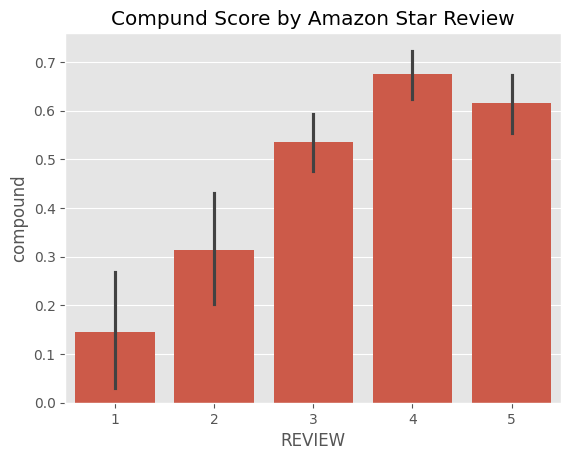

In [14]:
ax = sns.barplot(data=vaders, x='REVIEW', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

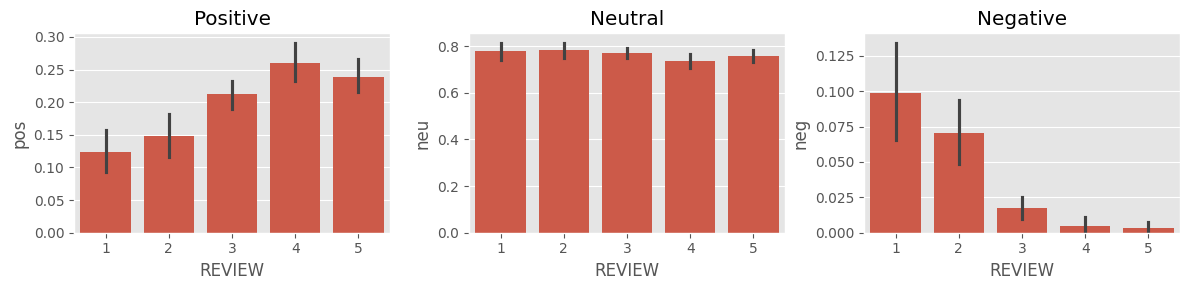

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='REVIEW', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='REVIEW', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='REVIEW', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# Run for RoBERTa Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.32794285, 'roberta_neu': 0.48213172, 'roberta_pos': 0.18992545}


In [19]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [20]:
text = "The classes are good but needs improvement"
polarity_scores_roberta(text)

{'roberta_neg': 0.028220292,
 'roberta_neu': 0.2745981,
 'roberta_pos': 0.69718164}

In [21]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.32794285, 'roberta_neu': 0.48213172, 'roberta_pos': 0.18992545}


In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
# VADER results on example
print(example)
sia.polarity_scores(example)

The session was too long and felt overwhelming. Breaking it into smaller, more digestible modules would help maintain focus. By the end, attention levels dropped. More concise sessions with short breaks would be beneficial.


{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6808}

In [24]:
polarity_scores_roberta("MVIT is a complete disappointment with poor management and outdated teaching methods. The faculty lacks proper knowledge and fails to guide students effectively. Infrastructure is subpar, and facilities are barely maintained. Overall, it's a waste of time and money—avoid at all costs.")

{'roberta_neg': 0.97211885,
 'roberta_neu': 0.024900585,
 'roberta_pos': 0.0029805203}

In [25]:
sia.polarity_scores("has a mix of positives and negatives. While the faculty and courses provide decent learning opportunities, there is room for improvement in management and infrastructure. Some facilities are well-maintained, but others need upgrades. Overall, it offers a moderate experience depending on individual expectations.")

{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'compound': 0.6124}

In [26]:
polarity_scores_roberta("has a mix of positives and negatives. While the faculty and courses provide decent learning opportunities, there is room for improvement in management and infrastructure. Some facilities are well-maintained, but others need upgrades. Overall, it offers a moderate experience depending on individual expectations.")

{'roberta_neg': 0.058888912,
 'roberta_neu': 0.36644447,
 'roberta_pos': 0.5746666}

In [27]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['NAME']
        myid = row['FEEDBACK']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/361 [00:00<?, ?it/s]

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'NAME'})
results_df = results_df.merge(df, how='left')

In [29]:
df.head()

,Timestamp,NAME,DEPARTMENT,FEEDBACK,SUMMARY,REVIEW
0,19/02/2025 21:02:18,Swati Sharma,IT,The examples provided were helpful but too few...,"Useful examples, but needs more",1
1,19/02/2025 21:02:47,\tManish Reddy,CSE,"The session was too long, making it difficult ...","Session too long, needs better pacing.",1
2,19/02/2025 21:06:38,Harish Kumar,CSE,"The Q&A session was too short, leaving many do...","Q&A too short, needs more time.",1
3,19/02/2025 21:07:23,Meenal Saxena,AIML,The practical examples were too simple and did...,"Simple examples, needs complexity.",1
4,19/02/2025 21:07:47,Vikas Malhotra,IOT,The session was informative but felt repetitiv...,"Repetitive, needs conciseness.",1


In [30]:
results_df.columns

Index(['NAME', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Timestamp', 'DEPARTMENT',
       'FEEDBACK', 'SUMMARY', 'REVIEW'],
      dtype='object')

In [31]:
results_df.head()

,NAME,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Timestamp,DEPARTMENT,FEEDBACK,SUMMARY,REVIEW
0,The examples provided were helpful but too few...,0.0,1.0,0.0,0.0,0.144329,0.736683,0.118988,NaN,NaN,NaN,NaN,NaN
1,"The session was too long, making it difficult ...",0.0,1.0,0.0,0.0,0.101054,0.802925,0.096022,NaN,NaN,NaN,NaN,NaN
2,"The Q&A session was too short, leaving many do...",0.0,1.0,0.0,0.0,0.173294,0.705601,0.121105,NaN,NaN,NaN,NaN,NaN
3,The practical examples were too simple and did...,0.0,1.0,0.0,0.0,0.165519,0.721147,0.113335,NaN,NaN,NaN,NaN,NaN
4,The session was informative but felt repetitiv...,0.0,1.0,0.0,0.0,0.135732,0.739766,0.124502,NaN,NaN,NaN,NaN,NaN


In [32]:
pd.DataFrame(results_df).to_csv("column_names.csv", index=False, header=False)